# 🧊 Exploratory Data Analysis (EDA)
This notebook explores the simulated cold storage temperature and humidity data.  
We aim to understand patterns, ranges, and relationships before modeling anomalies.


imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-whitegrid")


Load data

In [2]:
data_path = "../data/simulated_sensor_data.csv"
df = pd.read_csv(data_path, parse_dates=["timestamp"])
print("✅ Data loaded successfully!")
df.head()


✅ Data loaded successfully!


,timestamp,room_name,temperature,humidity
0,2025-10-01,Frozen_Storage_A,-18.94,51.91
1,2025-10-01,Frozen_Storage_B,-21.34,45.31
2,2025-10-01,Chilled_Storage_A,2.95,47.95
3,2025-10-01,Chilled_Storage_B,2.34,75.58
4,2025-10-01,Dispatch_Bay,11.13,57.34


Data Overview

In [3]:
df.info()
df.isna().sum()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    5376 non-null   datetime64[ns]
 1   room_name    5376 non-null   object        
 2   temperature  5376 non-null   float64       
 3   humidity     5376 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 168.1+ KB


,timestamp,temperature,humidity
count,5376,5376.000000,5376.000000
mean,2025-10-04 11:52:30,2.122000,60.283199
min,2025-10-01 00:00:00,-26.330000,40.000000
25%,2025-10-02 17:56:15,-6.070000,50.237500
50%,2025-10-04 11:52:30,4.905000,60.470000
75%,2025-10-06 05:48:45,12.740000,70.357500
max,2025-10-07 23:45:00,25.060000,80.000000
std,NaN,15.157174,11.595508


### 🧭 Data Overview
- Each record represents a 15-minute interval for a given room.  
- No missing values expected since data was simulated.  
- We'll check temperature and humidity ranges to ensure realism.


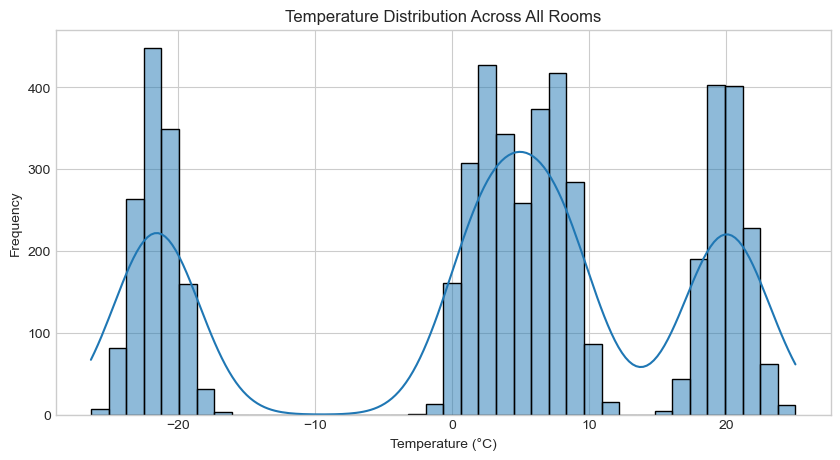

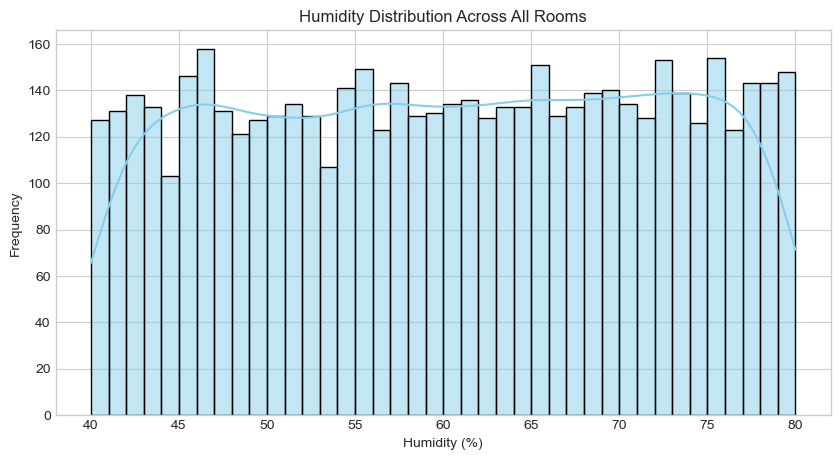

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(df["temperature"], kde=True, bins=40)
plt.title("Temperature Distribution Across All Rooms")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["humidity"], kde=True, bins=40, color="skyblue")
plt.title("Humidity Distribution Across All Rooms")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()


##### 🧊 Temperature Distribution Across All Rooms — Interpretation

The temperature data forms a **multimodal distribution** with three clear peaks, each representing a distinct thermal zone in the cold storage facility:

- **Frozen Storage (-25°C to -18°C):** The leftmost cluster corresponds to the frozen chambers, tightly controlled around subzero temperatures.  
- **Chilled Zones (0°C to 10°C):** The middle peak represents chilled rooms such as the Dispatch Bay and Receiving Zone, showing moderate variation.  
- **Ambient Areas (15°C to 25°C):** The rightmost cluster reflects rooms like Packaging and Maintenance, which operate at normal room temperatures.

**Insights:**
- The distinct clusters confirm that each temperature zone operates independently, as expected in a multi-zone cold storage facility.  
- The narrow spread within each cluster suggests stable temperature regulation.  
- No significant outliers are visible, indicating the simulated sensors are generating realistic readings.

**Conclusion:**  
The facility maintains well-separated and consistent thermal zones, providing a strong baseline for anomaly detection modeling.


#### 💧 Humidity Distribution Across All Rooms — Interpretation

The humidity readings appear to follow a **nearly uniform distribution** between 40% and 80%.  
This pattern is expected because humidity values were simulated using a uniform random generator.

**Observations:**
- The even spread suggests that humidity levels fluctuate naturally across time and rooms without clustering around a specific value.  
- Unlike temperature, humidity control in cold storage facilities is typically more flexible and may vary with airflow, door openings, and defrost cycles.  
- There are no extreme outliers, confirming that the simulated humidity data falls within realistic operational limits.

**Conclusion:**  
Humidity levels remain within the acceptable operational range (40–80%), exhibiting healthy variability consistent with environmental changes inside a working facility.  
This stable baseline will help the anomaly detection model distinguish between normal fluctuations and true humidity anomalies.


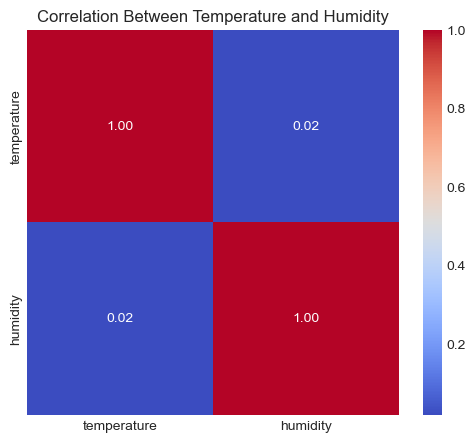

In [5]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[["temperature", "humidity"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Temperature and Humidity")
plt.show()


### 🔍 Preliminary Insights
- Frozen storage temperatures are tightly clustered around -22°C.  
- Chilled zones remain within 0–5°C, showing stable control.  
- Humidity varies widely (40–80%), indicating potential ventilation effects.  
- Weak correlation between temperature and humidity suggests separate control mechanisms.


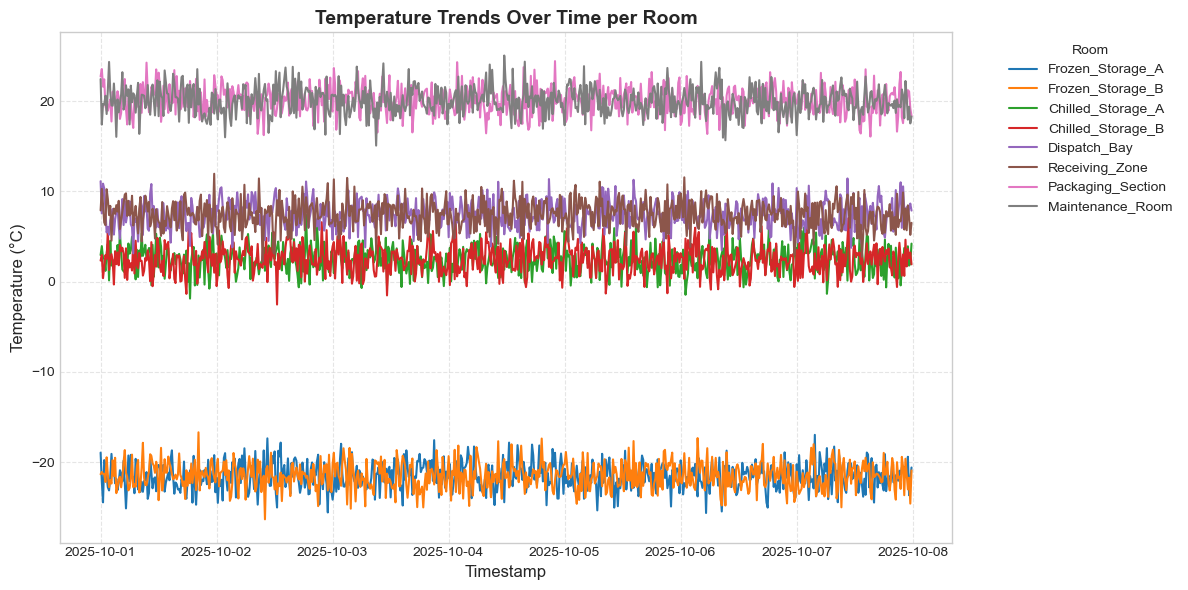

In [8]:
# Plot temperature trends over time per room
plt.figure(figsize=(12, 6))

# Line plot for each room
for room in df['room_name'].unique():
    subset = df[df['room_name'] == room]
    plt.plot(subset['timestamp'], subset['temperature'], label=room, linewidth=1.5)

plt.title('Temperature Trends Over Time per Room', fontsize=14, weight='bold')
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(title='Room', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##### Temperature Trends Over Time per Room

The plot above shows how temperature changes across different rooms over time.  
Each line represents one room, allowing us to observe:

- **General stability or fluctuations** in temperature across rooms.
- **Temporal patterns**, such as gradual warming or cooling over specific periods.
- **Potential outliers**, visible as sudden spikes or drops that deviate from the typical trend.

This visualization helps confirm the consistency of sensor readings and highlights any room that behaves unusually — a critical step before anomaly detection modeling.


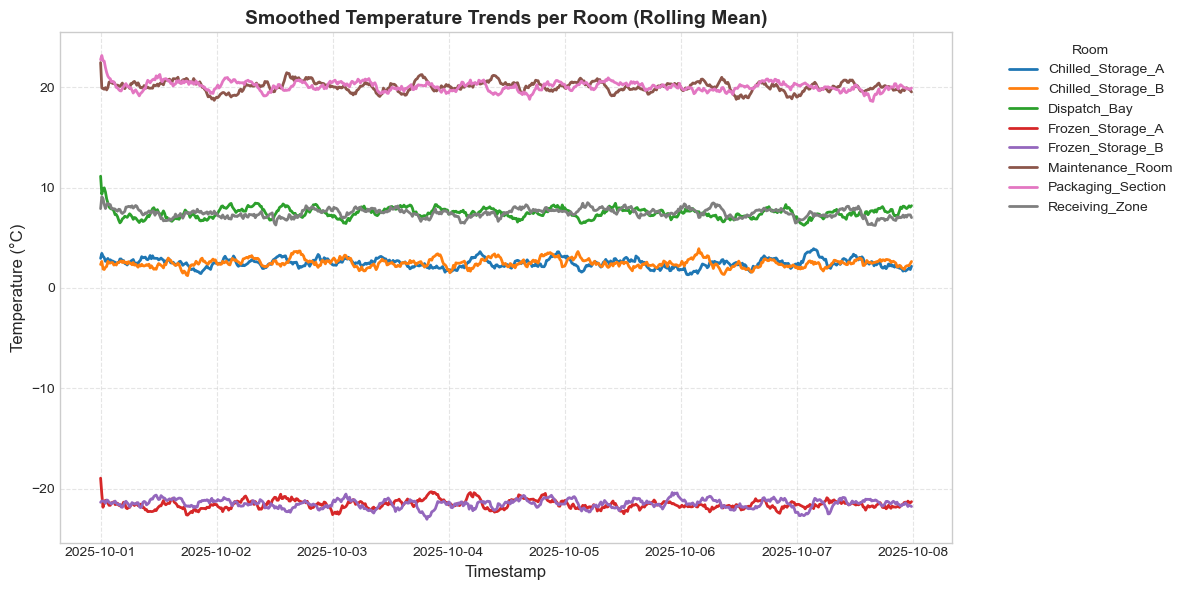

In [9]:
# Convert Timestamp to datetime if not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp for each room
df = df.sort_values(['room_name', 'timestamp'])

# Compute a rolling mean (window = 12 means ~12 readings; adjust based on frequency)
df['temp_Smoothed'] = df.groupby('room_name')['temperature'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

# Plot smoothed temperature trends per room
plt.figure(figsize=(12, 6))

for room in df['room_name'].unique():
    subset = df[df['room_name'] == room]
    plt.plot(subset['timestamp'], subset['temp_Smoothed'], label=room, linewidth=2)

plt.title('Smoothed Temperature Trends per Room (Rolling Mean)', fontsize=14, weight='bold')
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(title='Room', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##### Smoothed Temperature Trends per Room (Rolling Mean)

The smoothed temperature trends above filter out short-term noise to highlight broader patterns across rooms.  
By applying a rolling mean, we can better observe:

- **Long-term heating or cooling trends** that might align with daily or operational cycles.  
- **Differences in baseline temperatures** between rooms, which may indicate variations in insulation, ventilation, or sensor calibration.  
- **Gradual anomalies** that develop over time rather than sudden spikes.

This smoothed view provides a clearer foundation for detecting persistent anomalies and verifying the system’s thermal consistency.
